In [1]:
from pymatreader import read_mat
import os
os.environ["KERAS_BACKEND"] = "torch"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import numpy as np
import librosa
import scipy
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Conv2D, BatchNormalization, AveragePooling2D, Input, Flatten, Dense, Reshape, SpatialDropout2D, MultiHeadAttention, Conv1D, Dropout
from keras.layers import LayerNormalization, AveragePooling1D, RepeatVector, Multiply, Concatenate,GlobalAveragePooling1D, Add, DepthwiseConv2D, Masking,UpSampling2D
import torch
from keras.losses import CosineSimilarity
from torch.utils.data import Dataset
import tensorflow as tf
torch.set_default_device('cuda')
from sklearn.preprocessing import scale
from torch.utils.data import Dataset, DataLoader
import more_itertools
from keras_pos_embd import TrigPosEmbedding
from scipy.signal import sosfiltfilt, butter
from scipy.signal import sosfiltfilt, butter

#from keras_nlp.layers import TransformerEncoder


#torch.backends.cudnn.benchmark = True

In [2]:
X = np.load('sub1.npy')
stim1 = np.load('stim.npy')
stim2 = np.load('mask.npy')
#label = read_mat('ExJobb/y.mat')['label'][0:4]%2
#label = np.repeat(label.reshape(-1,1),33,axis=1)

In [3]:
Xx = []
stimulus = []
masker = []
for i in range(80):
    x = []
    for j in range(66):
        t = np.array(list(more_itertools.sliced(X[i][j],n=128)))
        x.append(t.T)
    Xx.append(np.asarray(x).T)
    stimulus.append(np.array(list(more_itertools.sliced(stim1[i],n=128))))
    masker.append(np.array(list(more_itertools.sliced(stim2[i],n=128))))

X = np.array(Xx)
stim = np.array(stimulus)
mask = np.array(masker)

X = X.reshape((80*33,128,66))
stim = stim.reshape((80*33,128))
mask = mask.reshape((80*33,128))
#label = label.reshape((80*33,1))

In [4]:
X_train,X_valid,y_tr,y_val,m,mv = train_test_split(X,stim,mask,test_size=0.2)

In [5]:
y_tr.shape

(2112, 128)

In [6]:
trsc = StandardScaler()
X_tr = []
X_val = []
for i in range(len(X_train)):
    X_tr.append(np.expand_dims(trsc.fit_transform(X_train[i]),axis=-1).astype(np.float32))

for i in range(len(X_valid)):
    X_val.append(np.expand_dims(trsc.fit_transform(X_valid[i]),axis=-1).astype(np.float32))
#X_test = np.expand_dims(trsc.fit_transform(respts),axis=-1).astype(np.float32)

X_tr = np.array(X_tr)
X_val = np.array(X_val)

trst = StandardScaler()
y_tr = trst.fit_transform(y_tr.T).astype(np.float32).T
y_val = trst.fit_transform(y_val.T).astype(np.float32).T
#y_test = trst.fit_transform(stimts).astype(np.float32)

trsm = StandardScaler()
m_tr = trsm.fit_transform(m.T).astype(np.float32).T
m_val = trsm.fit_transform(mv.T).astype(np.float32).T
#m_test = trsm.fit_transform(masts).astype(np.float32)

In [7]:
y_tr = np.expand_dims(y_tr,axis=-1)
y_val = np.expand_dims(y_val,axis=-1)
m_val = np.expand_dims(m_val,axis=-1)
m_tr = np.expand_dims(m_tr,axis=-1)

In [8]:
stimtr = np.roll(y_tr,1,axis=1)
stimval = np.roll(y_val,1,axis=1)
stimtr[:,0] = np.mean(X_tr,axis=2)[:,0]
stimval[:,0] =  np.mean(X_val,axis=2)[:,0]

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(((X_tr,stimtr),y_tr))
val_dataset = tf.data.Dataset.from_tensor_slices(((X_val,stimval),y_val))

In [10]:
train_dataset = train_dataset.batch(4).shuffle(32)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [11]:
val_dataset = val_dataset.batch(4)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [12]:
from keras import backend
from keras_core import ops

class SinePositionEncoding(torch.nn.Module):
    def __init__(self, max_wavelength=10000, **kwargs):
        super().__init__(**kwargs)
        self.max_wavelength = max_wavelength
        self.built = True

    def forward(self, inputs, start_index=0):
        shape = inputs.shape
        seq_length = shape[-2]
        hidden_size = shape[-1]
        positions = torch.arange(seq_length)
        positions = positions + start_index
        min_freq = 1 / self.max_wavelength
        timescales = min_freq ** (
            (2 * (torch.arange(hidden_size) // 2).to(torch.float32))
            / hidden_size
        )
        angles = positions.unsqueeze(1) * timescales.unsqueeze(0)
        # even indices are sine, odd are cosine
        cos_mask = torch.tensor(torch.arange(hidden_size) % 2, dtype=torch.float32)
        sin_mask = 1 - cos_mask
        # embedding shape is [seq_length, hidden_size]
        positional_encodings = (
            torch.sin(angles) * sin_mask + torch.cos(angles) * cos_mask
        )

        return positional_encodings.cpu()

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_wavelength": self.max_wavelength,
            }
        )
        return config

    def compute_output_shape(self, input_shape):
        return input_shape

Using PyTorch backend.


In [13]:
def Encoder(inputs,kdim,dropout,n_tr,n_heads):

    inp = Input((inputs))
    x = Conv2D(64,(1,8),activation="gelu",strides=(4,4),padding="valid")(inp)
    x = BatchNormalization()(x)
    x = DepthwiseConv2D(8,activation="gelu",padding="same")(x)
    x = Conv2D(16,(1,15),activation = "gelu")(x)
    x = Reshape((32,16))(x)
    #x = Dense(256)(x)
    d = Dense(kdim)(x)
    
    
    emb = SinePositionEncoding()(d)
    emb =  tf.convert_to_tensor(emb)
    x = d+emb
    #x = Add()([emb,d])
    

    for _ in range(n_tr):
        x1 = MultiHeadAttention(num_heads=n_heads,key_dim = kdim)(x,x)
        x2 = Add()([x1,x])
        x3 = LayerNormalization()(x2)
        x4 = Dense(kdim*2)(x3)
        x5 = Dense(kdim)(x4)
        x6 = Dropout(dropout)(x5)
        x = Add()([x6,x3])
        x = LayerNormalization()(x)
        
    return keras.Model(inp,x)

In [14]:
def Decoder(context,targs,kdim,dropout,n_tr,n_heads):
    tar = Input(targs)
    cont = Input(context)
    #tar = Conv1D(1,2,activation="gelu")(tar)

    #x = Conv1D(8,2,activation="gelu")(tar)
    tar = Masking(mask_value=0.)(tar)
    d = Conv1D(kdim,2,padding="causal",activation="gelu")(tar)
    emb = SinePositionEncoding()(d)
    emb = tf.convert_to_tensor(emb)
    x = d+emb
    #print(x.shape)

    for _ in range(n_tr):
        x1 = MultiHeadAttention(num_heads=n_heads,key_dim = kdim)(x,x,use_causal_mask=True)
        x2 = Add()([x1,x])
        x2 = LayerNormalization()(x2)
        x3 = MultiHeadAttention(num_heads=n_heads,key_dim = kdim)(x2,cont,use_causal_mask=True)
        x4 = Add()([x3,x2])
        x4 = LayerNormalization()(x4)
        x5 = Dense(2*kdim)(x4)
        x5 = Dense(kdim)(x5)
        x5 = Dropout(dropout)(x5)
        x5 = Add()([x4,x5])
        x = LayerNormalization()(x5)

    x = Dense(1)(x)

    return keras.Model((tar,cont),x)

In [15]:
def Transformer(inp_shape,kdim,dropout,n_tr,n_heads):
    inp = Input(inp_shape[0])
    tar = Input(inp_shape[1])
    enc_model = Encoder(inp_shape[0],kdim,dropout,n_tr,n_heads)
    context = enc_model(inp)
    sh2 = inp_shape[1]
    sh1 = context.shape[1:]
    dec_model = Decoder(sh1,sh2,kdim,dropout,n_tr,n_heads)
    out = dec_model((tar,context))
    return keras.Model((inp,tar),out)

In [16]:
inp_shape = [(128,66,1),(128,1)]
kdim = 32
dropout = 0.2
n_tr = 4
n_heads = 2

inp = Input(inp_shape[0])
tar = Input(inp_shape[1])
enc_model = Encoder(inp_shape[0],kdim,dropout,n_tr,n_heads)
context = enc_model(inp)
sh2 = inp_shape[1]
sh1 = context.shape[1:]
dec_model = Decoder(sh1,sh2,kdim,dropout,n_tr,n_heads)
out = dec_model((tar,context))

model = keras.Model((inp,tar),out)

C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\torch\utils\_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


In [17]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 66, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 1)]     0           []                               
                                                                                                  
 model (Functional)             (None, 32, 32)       71856       ['input_1[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 128, 1)       84993       ['input_2[0][0]',          

In [18]:
model.compile(optimizer=keras.optimizers.Nadam(),loss=keras.losses.MeanSquaredError(),metrics = [keras.metrics.CosineSimilarity()])

In [19]:
model.fit(train_dataset,epochs=10,validation_data = val_dataset)

Epoch 1/10
528/528 [==============================] - 63s 87ms/step - loss: 0.7502 - cosine_similarity: 0.3364 - val_loss: 0.6463 - val_cosine_similarity: 0.3888
Epoch 2/10
 24/528 [>.............................] - ETA: 43s - loss: 0.6576 - cosine_similarity: 0.3952

KeyboardInterrupt: 

In [22]:
def decode(Encoder,Decoder,eeg,y_val):
    context = Encoder.predict(eeg,verbose=False)
    tar = np.ones((1,128,1))*-10
    for i in range(127):
        out = Decoder.predict((tar,context),verbose=False)
        #print(out.shape)
        tar[0][i+1] = out[0][i]
        #print(tar[0][1:10])
    return out

In [23]:
pred = decode(enc_model,dec_model,np.expand_dims(X_val[2],axis=0),y_val[2])

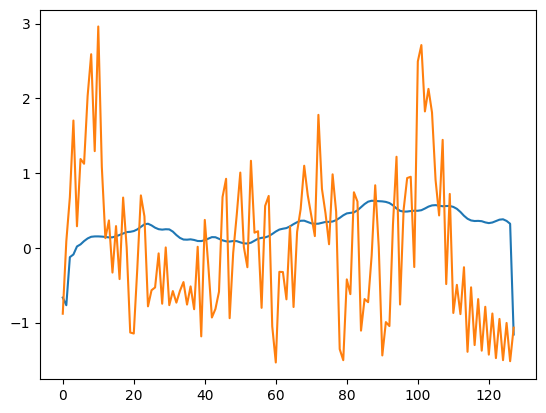

In [25]:
plt.plot(pred[0])
plt.plot(y_val[2])

In [66]:
np.std(pred[0])

0.22617158

In [55]:
from scipy.stats import pearsonr

total = 0
for i in range(10):
    pred = np.squeeze(decode(enc_model,dec_model,np.expand_dims(X_val[i],axis=0)))
    p = pearsonr(pred,np.squeeze(y_val[i]))
    m = pearsonr(pred,np.squeeze(m_val[i]))
    print(p.statistic)
    print(m.statistic)
    if p>m:
        total+=1
print(total/len(y_val))

0.3031151041603789
-0.4550092833358759
0.22675197119193363
-0.3436988957909297
-0.3903875740556414
0.024968178728252244
-0.021128625648223563
0.10155157915930266
0.12736869361772288
-0.16975069121675695
-0.27531509960892653
0.3873069772972818
0.2594701770635985
0.1053028063368121
0.2995975764646439
-0.11510650947230812
-0.2357430549997724
-0.1818277696804196
0.536272142703135
0.3574966205268815
0.011363636363636364


In [56]:
total

6

In [20]:
pred = model.predict(val_dataset)

132/132 [==============================] - 6s 30ms/step


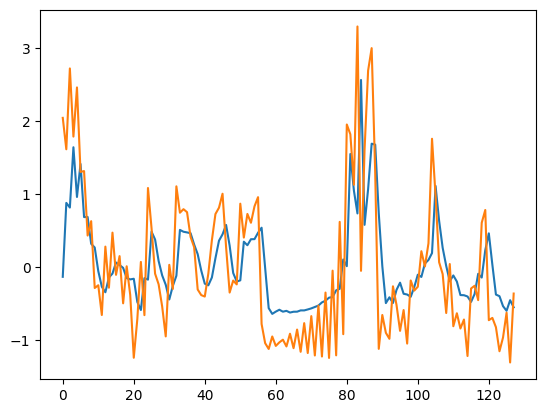

In [21]:
plt.plot(pred[0])
plt.plot(y_val[0])

In [102]:
def Transf(inputs,targs,kdim,dropout,n_tr,n_heads):

    inp = Input((inputs))
    x = Conv2D(64,(1,8),activation="gelu",strides=(4,4),padding="valid")(inp)
    x = BatchNormalization()(x)
    x = DepthwiseConv2D(8,activation="gelu",padding="same")(x)
    x = Conv2D(16,(1,15),activation = "gelu")(x)
    x = Reshape((32,16))(x)
    #x = Dense(256)(x)
    d = Dense(kdim)(x)
    
    
    emb = TrigPosEmbedding(input_shape=(4,),output_dim=kdim,mode=TrigPosEmbedding.MODE_EXPAND)(d)
    x = Add()([emb,d])

    for _ in range(n_tr):
        x1 = MultiHeadAttention(num_heads=n_heads,key_dim = kdim)(x,x)
        x2 = Add()([x1,x])
        x3 = LayerNormalization()(x2)
        x4 = Dense(kdim*2)(x3)
        x5 = Dense(kdim)(x4)
        x6 = Dropout(dropout)(x5)
        x = Add()([x6,x3])
    tar = Input(targs)
    cont = x
    #tar = Conv1D(1,2,activation="gelu")(tar)

    #x = Conv1D(8,2,activation="gelu")(tar)
    #tar = Masking(mask_value=0.)(tar)
    d = Conv1D(64,1,padding="same",activation="gelu")(tar)
    emb = TrigPosEmbedding(input_shape=(4,),output_dim=kdim,mode=TrigPosEmbedding.MODE_EXPAND)(d)
    x = Add()([emb,d])
    print(x.shape)

    for _ in range(n_tr):
        x1 = MultiHeadAttention(num_heads=n_heads,key_dim = kdim)(x,x,use_causal_mask=True)
        x2 = Add()([x1,x])
        x2 = LayerNormalization()(x2)
        x3 = MultiHeadAttention(num_heads=n_heads,key_dim = kdim)(x2,cont)
        x4 = Add()([x3,x2])
        x4 = LayerNormalization()(x4)
        x5 = Dense(2*kdim)(x4)
        x5 = Dense(kdim)(x5)
        x5 = Dropout(dropout)(x5)
        x5 = Add()([x4,x5])
        x = LayerNormalization()(x5)

    x = Dense(1)(x)
        
        
    return keras.Model((inp,tar),x)

In [103]:
model = Transf((128,66,1),(128,1),64,0.2,4,4)
model.summary()

(None, 128, 64)
Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_67 (InputLayer)          [(None, 128, 66, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_42 (Conv2D)             (None, 32, 15, 64)   576         ['input_67[0][0]']               
                                                                                                  
 batch_normalization_21 (BatchN  (None, 32, 15, 64)  256         ['conv2d_42[1][0]']              
 ormalization)                                                                                    
                                                                           

In [104]:
model.compile(optimizer=keras.optimizers.Nadam(),loss=keras.losses.MeanSquaredError(),metrics = [keras.metrics.CosineSimilarity()])

In [105]:
model.fit(train_dataset,epochs=10,validation_data = val_dataset)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/model_32/add_446/add/BroadcastGradientArgs' defined at (most recent call last):
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\gauta\AppData\Local\Temp\ipykernel_18736\2832722568.py", line 1, in <module>
      model.fit(train_dataset,epochs=10,validation_data = val_dataset)
    File "C:\Users\gauta\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\gauta\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\gauta\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\gauta\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\gauta\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\gauta\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\gauta\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\gauta\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "C:\Users\gauta\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model_32/add_446/add/BroadcastGradientArgs'
Incompatible shapes: [256,128,64] vs. [4,128,64]
	 [[{{node gradient_tape/model_32/add_446/add/BroadcastGradientArgs}}]] [Op:__inference_train_function_292971]

In [10]:
import keras_core

ModuleNotFoundError: No module named 'keras_core'

In [33]:
keras.backend.arange

<function keras.backend.arange(start, stop=None, step=1, dtype='int32')>